# Tree Models for Natural Fires

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xgboost

from all_col_queries import get_df

In [2]:
df_fires = get_df()

df_fires_encoded = pd.get_dummies(df_fires.drop(['fire_size_class'], axis=1), columns=['month', 'nutrient', 'rooting', 'oxygen', 'excess_salts', 'toxicity', 'workability'])
scaler = StandardScaler()
scaler.fit(df_fires_encoded)

X = scaler.transform(df_fires_encoded)
y = df_fires.fire_size_class > ''

num_fires = (y == True).sum()
num_data_pt = len(y)
print(f'{num_fires} fires out of {len(y)} data points')
print(f'No fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(f'X_train: {len(X_train)}, X_test: {len(X_test)}, y_train: {len(y_train)}, y_test: {len(y_test)}')

92659 fires out of 192659 data points
No fires 52.0% of the time
X_train: 144494, X_test: 48165, y_train: 144494, y_test: 48165


In [84]:
df_fires_encoded.columns

Index(['long', 'lat', 'date', 'precipitation', 'pressure', 'humidity_2m',
       'temp_2m', 'temp_dew_point_2m', 'temp_wet_bulb_2m', 'temp_max_2m',
       'temp_min_2m', 'temp_range_2m', 'temp_0m', 'wind_10m', 'wind_max_10m',
       'wind_min_10m', 'wind_range_10m', 'wind_50m', 'wind_max_50m',
       'wind_min_50m', 'wind_range_50m', 'drought_score', 'elevation',
       'slope_005', 'slope_005_02', 'slope_02_05', 'slope_05_10',
       'slope_10_15', 'slope_15_30', 'slope_30_45', 'slope_45', 'aspect_north',
       'aspect_east', 'aspect_south', 'aspect_west', 'water_land',
       'barren_land', 'urban_land', 'grass_land', 'forest_land',
       'partial_cultivated_land', 'irrigated_land', 'cultivated_land',
       'prior_fire_0_1_year', 'prior_fire_1_2_year', 'prior_fire_2_3_year',
       'prior_fire_3_4_year', 'prior_fire_4_5_year', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'nutrie

##### LogisticRegression

In [85]:
params={
  'C': [0.1],
}

log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg = GridSearchCV(estimator=log_reg, param_grid=params, scoring='recall', cv=5)

log_reg.fit(X_train, y_train)

print(f'All size fires estimator', log_reg.best_estimator_)

y_pred_log_reg = log_reg.predict(X_test)

print('--------- Log Regression Classification ---------')
print(classification_report(y_test, y_pred_log_reg))

All size fires estimator LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')
--------- Log Regression Classification ---------
              precision    recall  f1-score   support

       False       0.82      0.78      0.80     25048
        True       0.77      0.82      0.79     23117

    accuracy                           0.80     48165
   macro avg       0.80      0.80      0.80     48165
weighted avg       0.80      0.80      0.80     48165



In [86]:
# params = {
#     'n_estimators': np.arange(40, 100, 20),
#     'max_features': np.arange(4, 12, 1),
#     'max_depth': np.arange(10, 20, 2),
#     'min_samples_split': np.arange(4, 12, 2),
#     'min_samples_leaf': np.arange(2, 10, 2),
#     'max_leaf_nodes': np.arange(4, 10, 2),
# }
# For performance hardcode the latest best guess
params = {'n_estimators': [40], 'min_samples_split': [4], 'min_samples_leaf': [2],
          'max_leaf_nodes': [8], 'max_features': [10], 'max_depth': [18]}

rand_forest = GridSearchCV(RandomForestClassifier(), params, scoring="recall")

rand_forest.fit(X_train, y_train)

print(f'Best Params', rand_forest.best_params_)

print('--------- RandomForestClassifier Classification ---------')
y_pred_rand_forest = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred_rand_forest))

Best Params {'max_depth': 18, 'max_features': 10, 'max_leaf_nodes': 8, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 40}
--------- RandomForestClassifier Classification ---------
              precision    recall  f1-score   support

       False       0.78      0.79      0.79     25048
        True       0.77      0.76      0.77     23117

    accuracy                           0.78     48165
   macro avg       0.78      0.78      0.78     48165
weighted avg       0.78      0.78      0.78     48165



Text(0.5, 1.0, 'Random Forest feature importances')

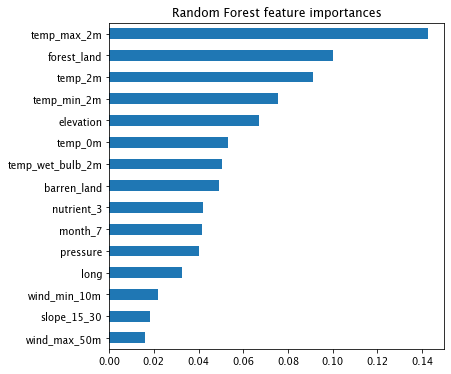

In [87]:
importances_rand_forest = rand_forest.best_estimator_.feature_importances_
importances_rand_forest = pd.Series(importances_rand_forest, index=df_fires_encoded.columns.values).sort_values().tail(15)

fig, ax = plt.subplots()
fig.set_figheight(6)
importances_rand_forest.plot.barh(ax=ax)
ax.set_title('Random Forest feature importances')

In [3]:
params={
  'objective': ['binary:logistic'],
  'max_depth': np.arange(3, 12, 3),
  'gamma': np.arange(0.1, 0.9, 0.1),
  'colsample_bytree': np.arange(0.2, 0.6, 0.2),
  'learning_rate': np.arange(0.1, 0.9, 0.1),
  'n_estimators': [200, 500],
  'eval_metric': ['error']
}
# For performance hardcode the latest best guess
# params={
#   'objective': ['binary:logistic'],
#   'max_depth': [9],
#   'gamma': [0.7],
#   'learning_rate': [0.3],
#   'n_estimators': [500],
#   'colsample_bytree': [0.4],
#   'eval_metric': ['error']
# }

xgb = xgboost.XGBClassifier(seed=42, use_label_encoder=False)

xgb = RandomizedSearchCV(xgb, params, scoring="recall", cv=3)

xgb.fit(X_train, y_train)

print("Best Params:", xgb.best_params_)

Best Params: {'objective': 'binary:logistic', 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.5, 'gamma': 0.6, 'eval_metric': 'error', 'colsample_bytree': 0.4}


In [4]:
y_pred_xgb = xgb.predict(X_test)

print('--------- XGBoost Classification Report ---------')
print(classification_report(y_test, y_pred_xgb))

--------- XGBoost Classification Report ---------
              precision    recall  f1-score   support

       False       0.92      0.88      0.90     25027
        True       0.87      0.91      0.89     23138

    accuracy                           0.90     48165
   macro avg       0.90      0.90      0.90     48165
weighted avg       0.90      0.90      0.90     48165



Text(0.5, 1.0, 'XGBoost feature importances')

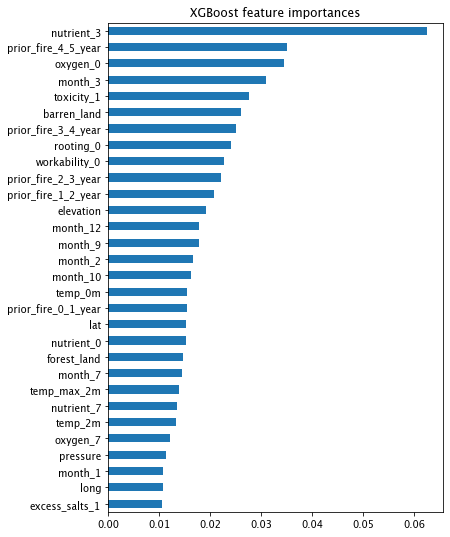

In [92]:
importances_xgb = xgb.best_estimator_.feature_importances_
importances_xgb = pd.Series(importances_xgb, index=df_fires_encoded.columns.values).sort_values().tail(30)

fig, ax = plt.subplots()
fig.set_figheight(9)
importances_xgb.plot.barh(ax=ax)
ax.set_title('XGBoost feature importances')

In [66]:
# from dtreeviz import trees 

# feat_cols = df_fires_encoded.columns.to_list()
# trees.dtreeviz(xgb.best_estimator_, X, y, feat_cols, 'Yes Fire', class_names=[0, 1], tree_index=1)

print("dtreeviz is really slow for this dataset so I've linked to an svg from a previous run below.")

dtreeviz is really slow for this dataset so I've linked to an svg from a previous run below.


![dtreeviz Decision Tree](./6_xgb_decision_tree.svg)

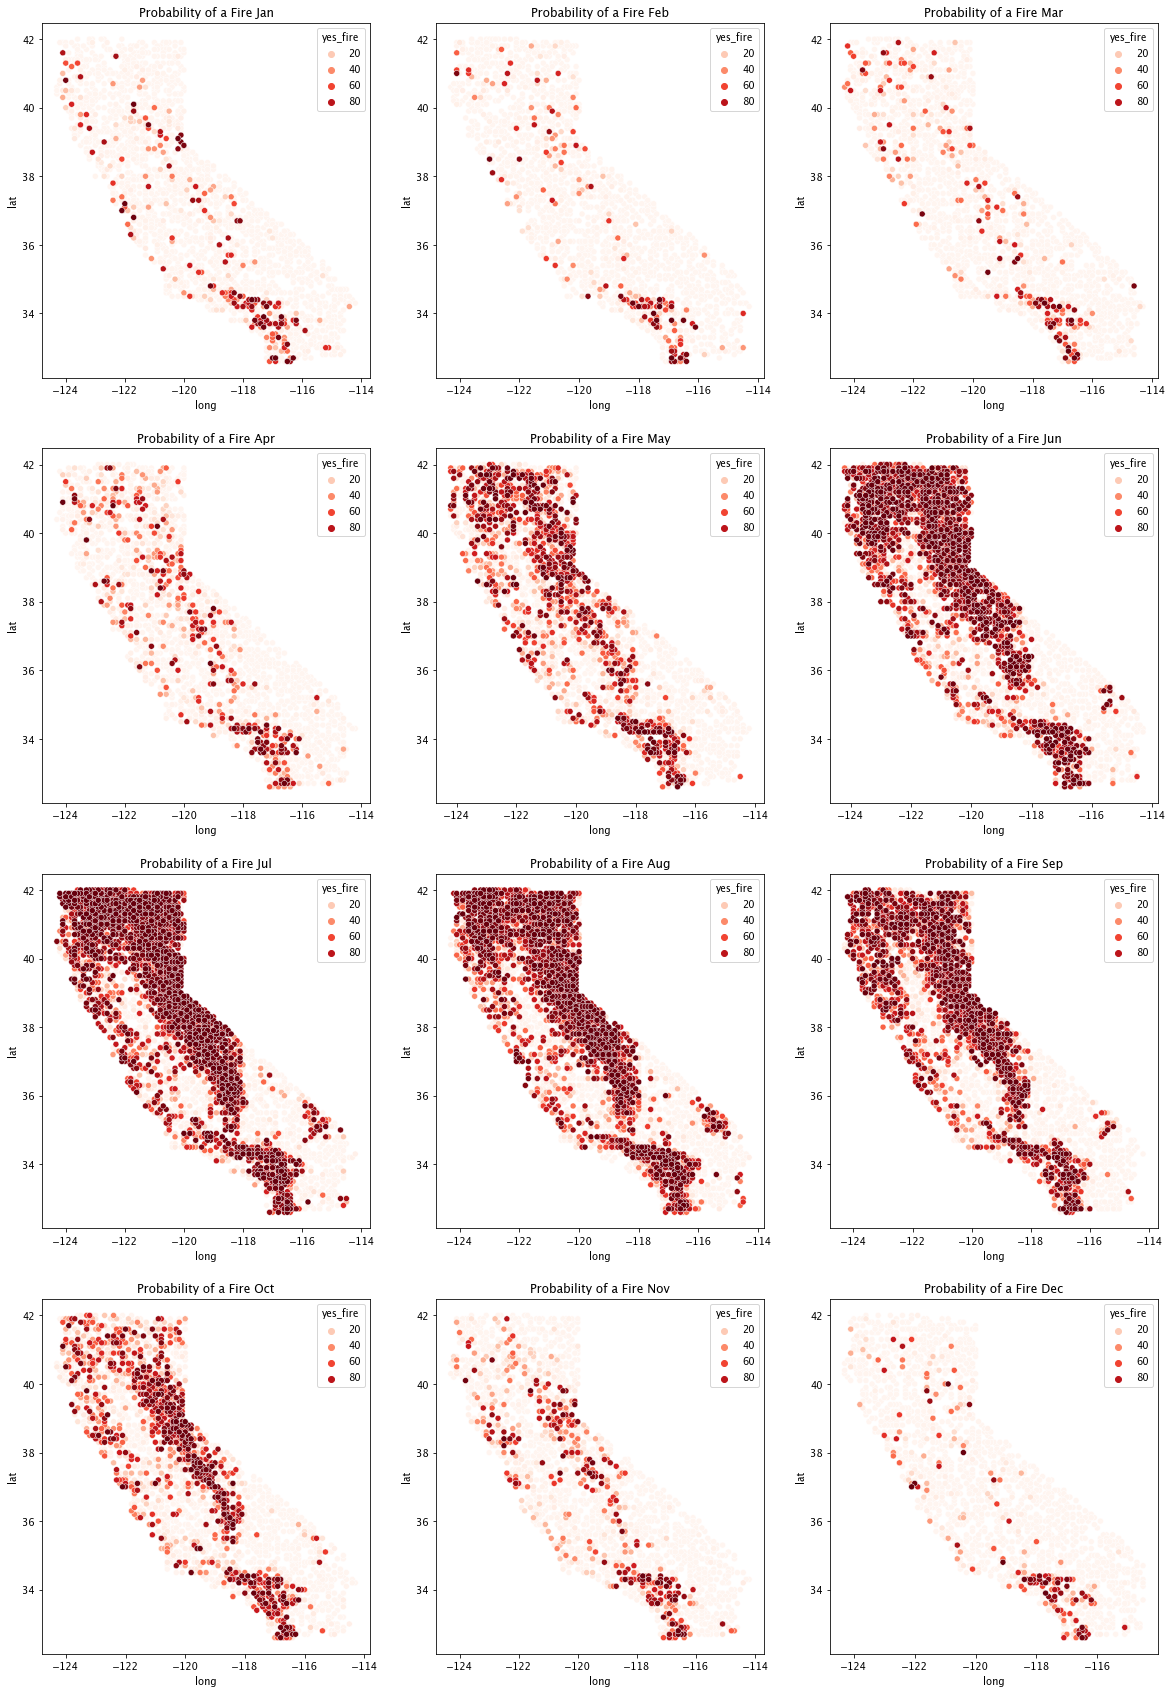

In [5]:
import datetime

proba_xgb = pd.DataFrame(xgb.predict_proba(X_test), columns=['no_fire', 'yes_fire'])
X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(df_fires, df_fires.fire_size_class > '', random_state=42)
X_orig_test = X_orig_test.reset_index(drop=True)
proba_xgb = pd.concat([X_orig_test, proba_xgb], axis=1)
proba_xgb['yes_fire'] = proba_xgb.yes_fire * 100
proba_xgb = proba_xgb.drop(columns=proba_xgb.columns.difference(['long', 'lat', 'month', 'yes_fire']))
proba_month = proba_xgb.groupby(['long', 'lat', 'month']).mean().reset_index().sort_values('yes_fire')

fig = plt.figure(figsize=(20, 30))

for i in range(1, 13):
    ax = plt.subplot(4, 3, i)
    mon = datetime.datetime.strptime(str(i), "%m").strftime("%b")

    plt.title(f'Probability of a Fire {mon}')
    sns.scatterplot(x='long', y='lat', data=proba_month[proba_month.month == i], palette='Reds', hue='yes_fire')

In [88]:
gbm = lgbm.LGBMClassifier(verbose=-1)

params = {
  'objective': ['binary'],
  'metric': ['binary_logloss'],
  'n_estimators': [1000],
  'learning_rate': [0.01, 0.2, 0.4],
  'num_leaves': [20, 40, 100, 500, 1000, 5000],
  'max_depth': np.arange(3, 12, 1),
  'min_data_in_leaf': np.arange(200, 10000, 200),
  'max_bin': [200, 300],
  'lambda_l1': np.arange(0, 100, 10),
  'lambda_l2': np.arange(0, 100, 10),
  'min_gain_to_split': np.arange(0, 10, 1),
  'feature_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_freq': [1],
}

# For performance use the best params
# params = {'objective': ['binary'], 'num_leaves': [5000], 'min_data_in_leaf': [800], 'metric': ['binary_logloss'], 'max_depth': [6],
#           'max_bin': [200], 'learning_rate': [0.8], 'feature_fraction': [0.2], 'bagging_freq': [1], 'bagging_fraction': [0.7]}

gbm = RandomizedSearchCV(estimator=gbm, param_distributions=params, scoring="recall", cv=3)
gbm.fit(X_train, y_train)


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.5000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.4000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4000000000000001
[LightGBM] [Warning] min_gain_to_split is set=7, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_l

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(verbose=-1),
                   param_distributions={'bagging_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'bagging_freq': [1],
                                        'feature_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'lambda_l1': array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
                                        'lambda_l2': array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
                                        'learning_rate': [0.01, 0.2, 0.4],
                                        'max_b...
                                        'min_data_in_leaf': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000, 2200,
       2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400,
       4600, 4800, 5000, 5200, 5400, 5600, 5800, 6000, 6200, 6400, 6600,
       6800, 7000, 7200, 7400, 7600, 7800, 8000, 8200, 8400,

In [89]:
print(f'Best params: {gbm.best_params_}')

y_pred_gbm = gbm.predict(X_test)

print('--------- LightGBM Classification Report ---------')
print(classification_report(y_test, y_pred_gbm))

Best params: {'objective': 'binary', 'num_leaves': 20, 'n_estimators': 1000, 'min_gain_to_split': 7, 'min_data_in_leaf': 1000, 'metric': 'binary_logloss', 'max_depth': 3, 'max_bin': 300, 'learning_rate': 0.2, 'lambda_l2': 50, 'lambda_l1': 10, 'feature_fraction': 0.5000000000000001, 'bagging_freq': 1, 'bagging_fraction': 0.4000000000000001}
--------- LightGBM Classification Report ---------
              precision    recall  f1-score   support

       False       0.85      0.82      0.84     25048
        True       0.81      0.84      0.83     23117

    accuracy                           0.83     48165
   macro avg       0.83      0.83      0.83     48165
weighted avg       0.83      0.83      0.83     48165



Text(0.5, 1.0, 'LGBM feature importances')

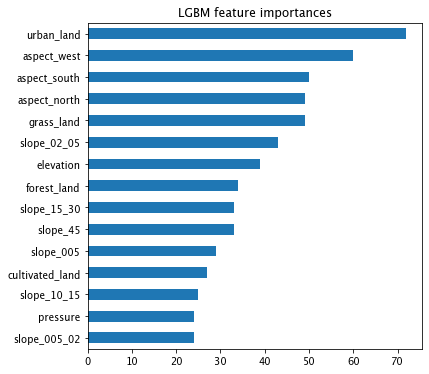

In [70]:
importances_gbm = gbm.best_estimator_.feature_importances_
importances_gbm = pd.Series(importances_gbm, index=df_fires_encoded.columns.values).sort_values().tail(15)

fig, ax = plt.subplots()
fig.set_figheight(6)
importances_gbm.plot.barh(ax=ax)
ax.set_title('LGBM feature importances')

In [71]:
gbm = lgbm.LGBMClassifier()

# scale_pos_weight=300,
gbm = lgbm.LGBMClassifier(objective='binary', num_leaves=100, min_data_in_leaf=200, metric='binary_logloss', max_depth=7,
                          max_bin=300, learning_rate=0.2, feature_fraction=0.5, bagging_freq=5, bagging_fraction=0.7)

drop_cols = [17, 28, 33, 34, 61]

X_train_best = np.delete(X_train, drop_cols, axis=1)
X_test_best = np.delete(X_test, drop_cols, axis=1)

gbm.fit(X_train_best, y_train)
y_pred = gbm.predict(X_test_best)
best_recall = recall_score(y_test, y_pred)

print(f'Recall for all columns: {best_recall}')

# Remove features one at a time to see if the feature is valuable
for i in range(X_train.shape[1]):
  if i not in drop_cols:
    drop_cols_try = drop_cols + [i]
    X_train_try = np.delete(X_train, drop_cols_try, axis=1)
    gbm.fit(X_train_try, y_train)

    X_test_try = np.delete(X_test, drop_cols_try, axis=1)
    y_pred = gbm.predict(X_test_try)

    recall = recall_score(y_test, y_pred)

    print(f'Recall for dropping {i} col: {recall}')

    if recall > best_recall:
      drop_cols.append(i)
      print(f'Drop cols {drop_cols}')
      best_recall = recall

drop_cols

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Recall for all columns: 0.99576509226049
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Recall for dr

KeyboardInterrupt: 